In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

print(" Загрузка датасета Boston Housing...")

# Загрузка данных
boston = fetch_openml(name='boston', version=1, as_frame=True)
data = boston.frame
target = boston.target

print(" Данные успешно загружены!")
print(f" Размер выборки: {data.shape}")

# Создание DataFrame для анализа
feature_names = list(boston.feature_names) if hasattr(boston, 'feature_names') else list(data.columns)

print("\n Статистика выборки:")
print(data.describe())

# Разделение на обучающую и тестовую выборки
train_data, test_data, train_labels, test_labels = train_test_split(
    data, target, test_size=0.2, random_state=1728
)

print(f" Обучающая выборка: {train_data.shape}")
print(f" Тестовая выборка: {test_data.shape}")

# Нормализация данных
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)
test_data_norm = scaler.transform(test_data)

print("\n Данные нормализованы")


 Загрузка датасета Boston Housing...
 Данные успешно загружены!
 Размер выборки: (506, 14)

 Статистика выборки:
             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT        MEDV  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000

In [11]:

# СОЗДАНИЕ МОДЕЛИ

def create_regression_model():
    """
    Создание регрессионной модели согласно варианту 20:
    - 4 скрытых слоя: 32-16-32-16 нейронов
    - Функции активации: relu-relu-relu-elu
    """
    model = MLPRegressor(
        hidden_layer_sizes=(32, 16, 32, 16),
        activation='relu',  # Основная активация
        alpha=0.001,        # Регуляризация L2
        learning_rate_init=0.001,
        max_iter=200,
        batch_size=32,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        verbose=False
    )
    return model

# Создаем модель
model = create_regression_model()

print("\n Архитектура модели (аналог Варианта 20):")
print(f"Скрытые слои: {model.hidden_layer_sizes}")
print(f"Функция активации: {model.activation}")
print(f"Оптимизатор: adam")  # по умолчанию в sklearn



 Архитектура модели (аналог Варианта 20):
Скрытые слои: (32, 16, 32, 16)
Функция активации: relu
Оптимизатор: adam


In [12]:
# КРОСС-ВАЛИДАЦИЯ

print("\n ВЫПОЛНЕНИЕ КРОСС-ВАЛИДАЦИИ...")

k = 5  # Количество блоков
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_data_norm)):
    print(f"\n Блок {fold + 1}/{k}")

    # Разделение данных
    X_train_fold = train_data_norm[train_idx]
    y_train_fold = train_labels.iloc[train_idx]
    X_val_fold = train_data_norm[val_idx]
    y_val_fold = train_labels.iloc[val_idx]

    # Создание и обучение модели для текущего блока
    fold_model = create_regression_model()
    fold_model.fit(X_train_fold, y_train_fold)

    # Предсказание на валидационных данных
    y_val_pred = fold_model.predict(X_val_fold)

    # Оценка на валидационных данных
    val_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_mse = mean_squared_error(y_val_fold, y_val_pred)

    mae_scores.append(val_mae)
    mse_scores.append(val_mse)

    print(f"   MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")

# Результаты кросс-валидации
print(f"\n РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ ({k} блока):")
print(f"   Средний MAE: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
print(f"   Средний MSE: {np.mean(mse_scores):.4f}")




 ВЫПОЛНЕНИЕ КРОСС-ВАЛИДАЦИИ...

 Блок 1/5
   MAE: 0.6407, MSE: 0.9035

 Блок 2/5
   MAE: 0.7253, MSE: 1.4218

 Блок 3/5
   MAE: 0.7056, MSE: 0.8921

 Блок 4/5
   MAE: 0.8144, MSE: 1.9315

 Блок 5/5
   MAE: 0.7690, MSE: 0.9908

 РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ (5 блока):
   Средний MAE: 0.7310 (+/- 0.0587)
   Средний MSE: 1.2279


In [13]:
# ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ

print("\n ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ...")

# Обучение на всей обучающей выборке
final_model = create_regression_model()

# Для мониторинга обучения разобьем на обучающую и валидационную выборку
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    train_data_norm, train_labels, test_size=0.2, random_state=42
)


final_model.fit(X_train_final, y_train_final)

# Предсказания для визуализации обучения
train_pred = final_model.predict(X_train_final)
val_pred = final_model.predict(X_val_final)

train_mae = mean_absolute_error(y_train_final, train_pred)
val_mae = mean_absolute_error(y_val_final, val_pred)
train_mse = mean_squared_error(y_train_final, train_pred)
val_mse = mean_squared_error(y_val_final, val_pred)

print(f"Обучение завершено!")
print(f"MAE на обучении: {train_mae:.4f}, на валидации: {val_mae:.4f}")
print(f"MSE на обучении: {train_mse:.4f}, на валидации: {val_mse:.4f}")


 ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ...
Обучение завершено!
MAE на обучении: 0.6036, на валидации: 0.7812
MSE на обучении: 0.5894, на валидации: 1.1558


In [14]:
# ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ

print("\n ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ...")

test_pred = final_model.predict(test_data_norm)

test_mae = mean_absolute_error(test_labels, test_pred)
test_mse = mean_squared_error(test_labels, test_pred)

print(f" Результаты на тестовых данных:")
print(f"   Среднеквадратическая ошибка (MSE): {test_mse:.4f}")
print(f"   Средняя абсолютная ошибка (MAE): {test_mae:.4f}")
print(f"   Это означает: модель ошибается в среднем на ${test_mae * 1000:.0f}")


 ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ...
 Результаты на тестовых данных:
   Среднеквадратическая ошибка (MSE): 0.9474
   Средняя абсолютная ошибка (MAE): 0.7460
   Это означает: модель ошибается в среднем на $746



ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...


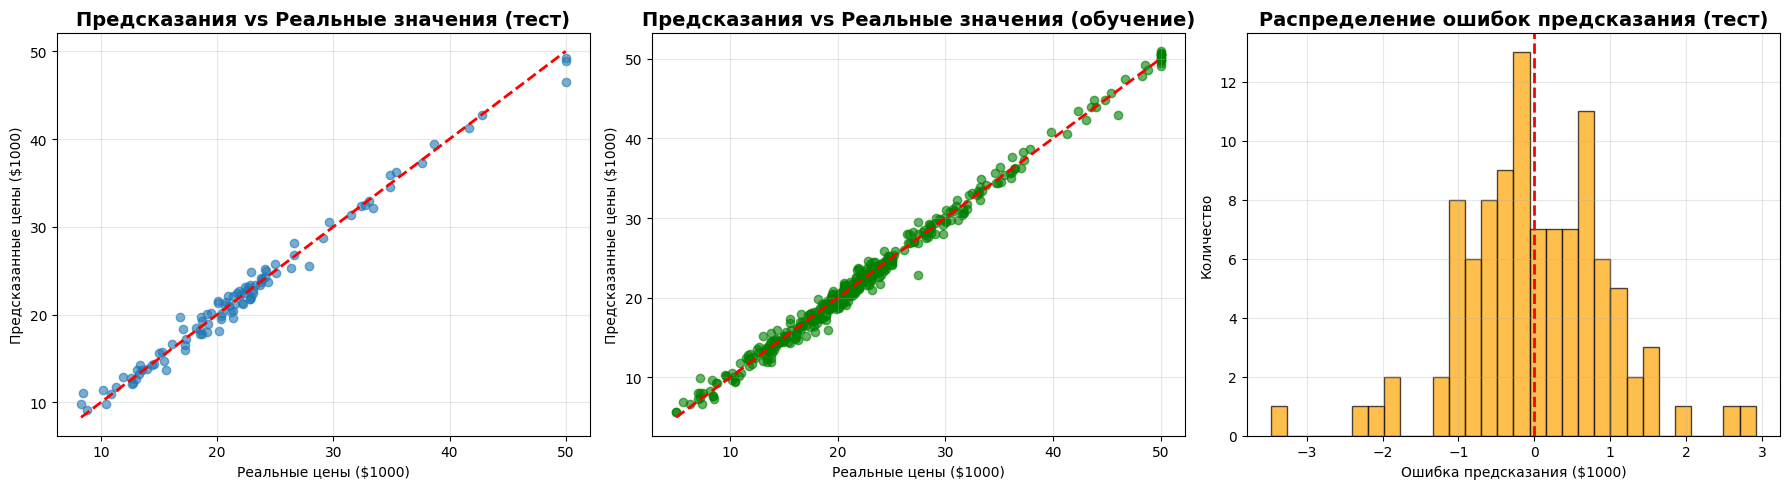

In [28]:
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Сравнение предсказаний с реальными значениями (тестовые данные)
axes[0].scatter(test_labels, test_pred, alpha=0.6)
axes[0].plot([test_labels.min(), test_labels.max()],
            [test_labels.min(), test_labels.max()], 'r--', lw=2)
axes[0].set_title('Предсказания vs Реальные значения (тест)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Реальные цены ($1000)')
axes[0].set_ylabel('Предсказанные цены ($1000)')
axes[0].grid(True, alpha=0.3)

# 2. Сравнение предсказаний с реальными значениями (обучающие данные)
train_full_pred = final_model.predict(train_data_norm)
axes[1].scatter(train_labels, train_full_pred, alpha=0.6, color='green')
axes[1].plot([train_labels.min(), train_labels.max()],
            [train_labels.min(), train_labels.max()], 'r--', lw=2)
axes[1].set_title('Предсказания vs Реальные значения (обучение)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Реальные цены ($1000)')
axes[1].set_ylabel('Предсказанные цены ($1000)')
axes[1].grid(True, alpha=0.3)

# 3. Распределение ошибок на тестовых данных
test_errors = test_pred - test_labels
axes[2].hist(test_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Распределение ошибок предсказания (тест)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Ошибка предсказания ($1000)')
axes[2].set_ylabel('Количество')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()